In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from iactrace import (
    Telescope, MCIntegrator, hexshow, squareshow
)

# Import HESS I telescope configuration:

In [12]:
%%time
integrator = MCIntegrator(64, 30.0) # This defines the sampler to sample N points per mirror facet, also defining microfacet roughness
telescope = Telescope.from_yaml('../configs/HESS/CT1.yaml', integrator, sampling_key = jax.random.key(42))

CPU times: user 1.15 s, sys: 200 ms, total: 1.35 s
Wall time: 1.03 s


# Simulating a star field:

In [35]:
# Generate star field
n_stars = 10000
key = jax.random.key(42)
key1, key2 = jax.random.split(key)

# Small angular region (6 degrees field of view)
fov_deg = 6
fov_rad = fov_deg * jnp.pi / 180

x = jax.random.uniform(key1, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
y = jax.random.uniform(key2, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
z = -jnp.ones(n_stars)

stars = jnp.stack([x, y, z], axis=1)
stars = stars / jnp.linalg.norm(stars, axis=1, keepdims=True)

# Set random flux values for stars:
key = jax.random.key(4242)
f_stars = 10**(-10*jax.random.uniform(key, shape=(len(stars),)))

In [40]:
%%time
image_science = telescope(stars, f_stars, source_type='infinity', sensor_idx=0).block_until_ready()
image_lid = telescope(stars, f_stars, source_type='infinity', sensor_idx=1).block_until_ready()

CPU times: user 5.03 ms, sys: 1.19 ms, total: 6.22 ms
Wall time: 836 ms


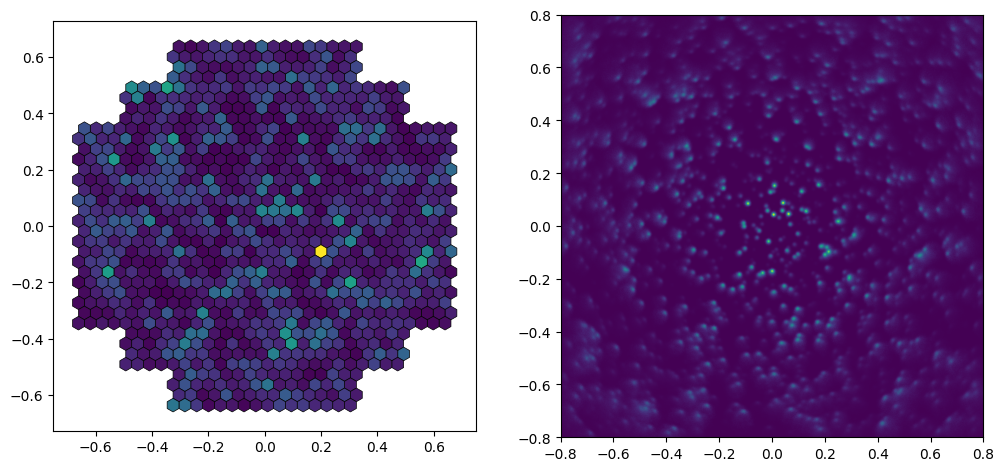

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax_hex = hexshow(image_science, telescope.sensors[0], ax=ax[0])
ax_square = squareshow(image_lid, telescope.sensors[1], ax=ax[1])

# Simulating a point source at finite distance:

In [42]:
N_points = 1

key = jax.random.key(12)
key1, key2 = jax.random.split(key)

x = jax.random.uniform(key1, N_points, minval=-0.0001, maxval=0.0001)
y = jax.random.uniform(key2, N_points, minval=-0.0001, maxval=0.0001)
z = jnp.ones(N_points) * 250

points = jnp.array([x,y,z]).T
f_points = np.ones(len(points))

In [43]:
%%time
image_science = telescope(points, f_points, source_type='point', sensor_idx=0).block_until_ready()
image_lid = telescope(points, f_points, source_type='point', sensor_idx=1).block_until_ready()

CPU times: user 5.64 ms, sys: 401 µs, total: 6.04 ms
Wall time: 21.1 ms


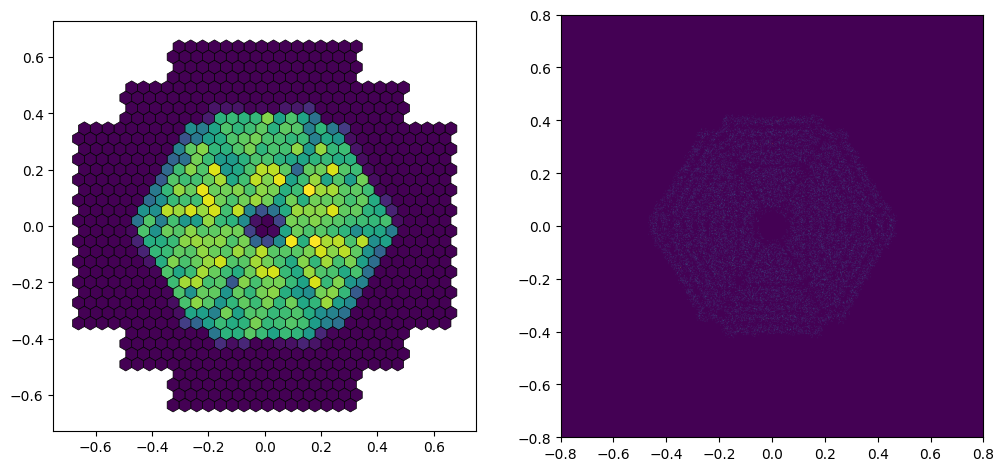

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax_hex = hexshow(image_science, telescope.sensors[0], ax=ax[0])
ax_square = squareshow(image_lid, telescope.sensors[1], ax=ax[1])